<a href="https://colab.research.google.com/github/Thiagokiam/CNN_Models_DeepLearning/blob/main/Preprocessing_Data_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing MicroCT

## Open data

In [ ]:
import cv2 as cv
import time, os
import numpy as np
import pandas as pd

def ConversaoDataFrame (diretorio_imagens, diretorio_dados, diretorio_perneabilidade):
  # Diretórios das imagens e dos dados
  diretorio_imagens = diretorio_imagens
  diretorio_dados = diretorio_dados
  diretorio_perneabilidade = diretorio_perneabilidade

  arquivos = sorted(os.listdir(diretorio_imagens))
  dados = sorted(os.listdir(diretorio_dados))

  dados_permeabilidade = pd.read_excel(diretorio_perneabilidade, sheet_name = 'Planilha1')
  dados_permeabilidade['Permeabilidade (mD)'][0]

  # Coletando cada uma das imagens
  imagem = []
  for i in np.arange(len(arquivos)):
    diretorio = diretorio_imagens + str(arquivos[i]) + '/'
    lista_imagens = sorted(os.listdir(diretorio))
    img = []
    for j in np.arange(len(lista_imagens)):
      diretorio_imgem = diretorio + lista_imagens[j]
      img.append(cv.imread(diretorio_imgem, cv.IMREAD_GRAYSCALE))
    imagem.append(img)

  amostras = len(imagem)        # Quantidade de amostras
  n_imagens = len(imagem[0])    # Quantidade de imagens que cada amostra possui

  # Coletando cada um dos Threshould's
  dados_threshould = []
  nome_amostra = []
  for i in np.arange(amostras):
    dir_dados = diretorio_dados + str(dados[i])
    arqu = pd.read_csv(dir_dados, sep = ':').T.reset_index().drop('index', axis = 1).T
    treshould = []
    for j in np.arange(n_imagens):
      treshould.append(int(arqu[1][j][1:-4]))
      nome_amostra.append(dados[i][:3])
    dados_threshould.append(treshould)


  # Obtendo os histogramas, a escala de cinza e a multiplicação
  escala_cinza = np.arange(255, -1, -1)
  histogramas = []
  multiplicacao_hist_cinza = []
  soma_multiplicacao = []

  for i in np.arange(amostras):
    threshould = dados_threshould[i]
    image = imagem[i]
    histograma = []
    multiplicacao = []
    soma = []
    for j in np.arange(n_imagens):
      histg = cv.calcHist([image[j]], [0], None, [256], [0,256])
      mult = histg[:threshould[j]].T[0]*escala_cinza[:threshould[j]]
      histograma.append(histg)
      multiplicacao.append(mult)
      soma.append(sum(mult))
    histogramas.append(histograma)
    multiplicacao_hist_cinza.append(multiplicacao)
    soma_multiplicacao.append(soma)


  # Calculando a permeabilidade em cada Slice
  permeabilidade_slice = []
  for i in np.arange(amostras):
    k_slice = []
    for j in np.arange(n_imagens):
      soma_amostra = sum(soma_multiplicacao[i])/n_imagens
      k_gas = dados_permeabilidade['Permeabilidade (mD)'][i]
      soma_slice = soma_multiplicacao[i][j]
      k_slice.append(k_gas*soma_slice/soma_amostra)
    permeabilidade_slice.append(k_slice)

  # Criando DataFrame com os dados da imagem e permeabilidade
  lista_imagem = []
  permeabilidade_input = []
  for i in np.arange(amostras):
    for j in np.arange(n_imagens):
      #reshape = imagem[i][j].reshape(1, pixel_imagem*pixel_imagem)
      lista_imagem.append(imagem[i][j])
      permeabilidade_input.append(permeabilidade_slice[i][j])

  dados_entrada = pd.DataFrame({'Amostra': nome_amostra,
                                'Imagem': lista_imagem,
                                'Permeabilidade': permeabilidade_input})

  return dados_entrada

    # Criando tensores
    imagem_tensor = []
    permeabilidade_tns = torch.from_numpy(np.array(permeabilidade_slice).astype(np.float32))
    for i in np.arange(amostras):
      for j in np.arange(n_imagens):
        #reshape = imagem[i][j].reshape(1, pixel_imagem*pixel_imagem)
        con_tns = torch.Tensor(imagem[i][j])
        img_tns = con_tns.view(1, con_tns.size(0), con_tns.size(1))
        imagem_tensor.append(img_tns)

    dados_entrada = pd.DataFrame({'Amostra': nome_amostra,
                                'Imagem_tensor': imagem_tensor,
                                'Permeabilidade': permeabilidade_tns})

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Abertura dos Dados

In [ ]:
diretorio_imagens = '/content/drive/MyDrive/Projeto_CNN/Imagens/'
diretorio_dados = '/content/drive/MyDrive/Projeto_CNN/Dados_Threshould/'
diretorio_perneabilidade = '/content/drive/MyDrive/Projeto_CNN/Permeabilidade_Carbo_CNN.xlsx'
df = ConversaoDataFrame(diretorio_imagens,diretorio_dados, diretorio_perneabilidade)

## Avaliando os dados

In [ ]:
# Conferindo a permeabilidade da amostra utilizando o modelo de permeabilidade em série
dados_permeabilidade = pd.read_excel(diretorio_perneabilidade, sheet_name = 'Planilha1')
fracao_permeabilidade = []
q_amostars = len(df['Amostra'].unique())
n_imagens = len(df)/q_amostars

for i in np.arange(q_amostars):
  fracao = []
  for j in np.arange(n_imagens):
    if i == 0:
      fracao.append(35/df['Permeabilidade'][j])
    else:
      fracao.append(35/df['Permeabilidade'][n_imagens*i+j])
  fracao_permeabilidade.append(fracao)

permeabilidade_serie = []
for i in np.arange(q_amostars):
  permeabilidade_serie.append(35*n_imagens/sum(fracao_permeabilidade[i]))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, explained_variance_score

In [ ]:
dados_permeabilidade['Permeabilidade (mD)']

0     0.009224
1     0.117000
2     2.885684
3    12.473430
4    48.980610
5     0.028817
Name: Permeabilidade (mD), dtype: float64

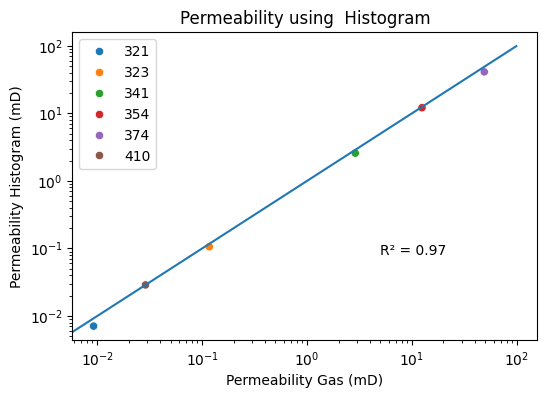

In [ ]:
reta = pd.DataFrame({'x' : np.arange(100),
                     'y' : np.arange(100)})

plt.subplots(figsize = (6,4))

sns.scatterplot(x = dados_permeabilidade['Permeabilidade (mD)'],
                y = permeabilidade_serie,
                hue = df['Amostra'].unique())

sns.lineplot(data = reta,
               x = 'x',
               y = 'y')
r2 = r2_score(dados_permeabilidade['Permeabilidade (mD)'], permeabilidade_serie)

plt.yscale('log')
plt.xscale('log')
plt.xlabel('Permeability Gas (mD)')
plt.ylabel('Permeability Histogram (mD)')
plt.title('Permeability using  Histogram')
plt.text(5, 0.08, 'R² = %0.2f' % r2 )
plt.show()

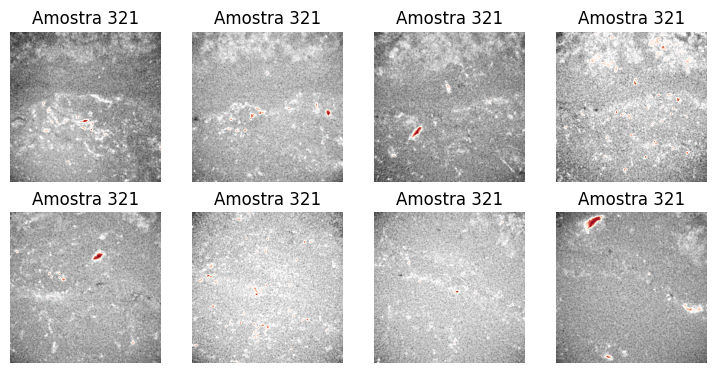

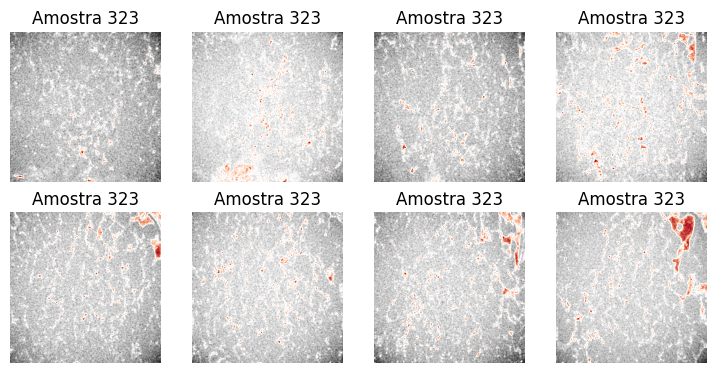

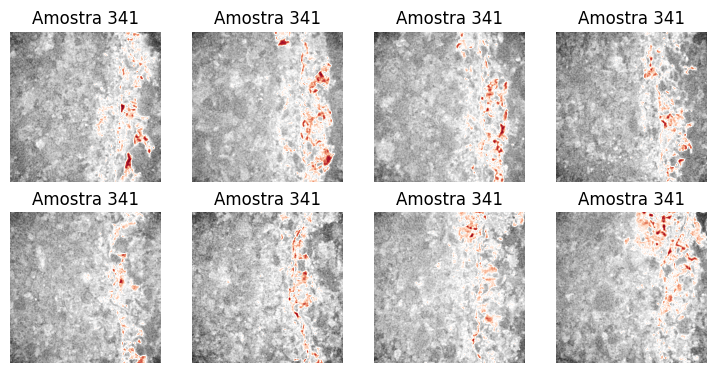

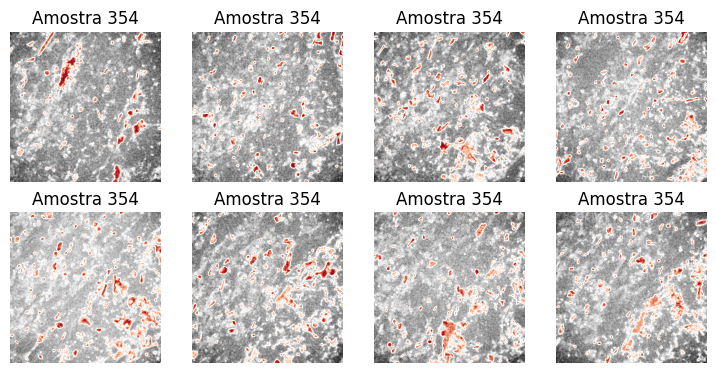

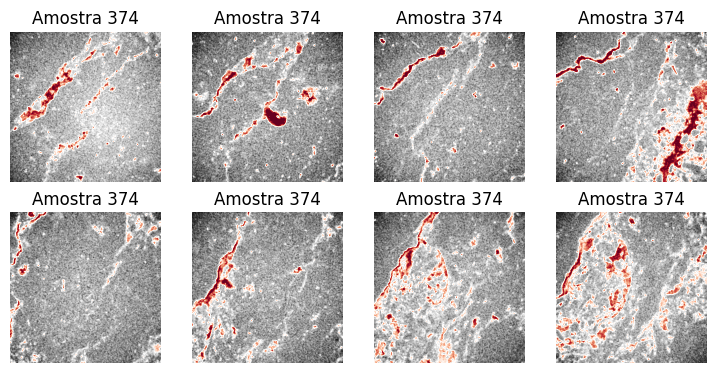

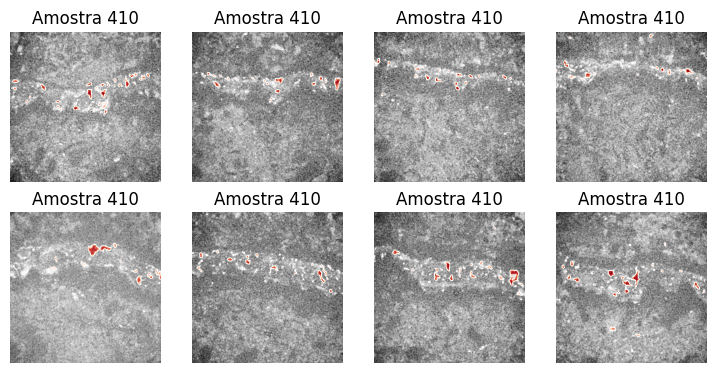

In [ ]:
reshape_imagens = []
imagem_titulo = []
for i in np.arange(q_amostars+q_amostars):
  for j in np.arange(4):
    if i == 0:
      reshape_imagens.append(df['Imagem'][j*100])
      imagem_titulo.append(df['Amostra'][500*i+j*100])
    else:
      reshape_imagens.append(df['Imagem'][500*i+j*100])
      imagem_titulo.append(df['Amostra'][500*i+j*100])

for i in np.arange(int(len(reshape_imagens)/8)):
  plt.figure(figsize=(9,9))
  plt.subplot(441); plt.imshow(reshape_imagens[i*8], cmap = 'RdGy'); plt.title('Amostra ' + str(imagem_titulo[i*8])); plt.axis("off")
  plt.subplot(442); plt.imshow(reshape_imagens[i*8+1], cmap = 'RdGy'); plt.title('Amostra ' + str(imagem_titulo[i*8+1])); plt.axis("off")
  plt.subplot(443); plt.imshow(reshape_imagens[i*8+2], cmap = 'RdGy'); plt.title('Amostra ' + str(imagem_titulo[i*8+2])); plt.axis("off")
  plt.subplot(444); plt.imshow(reshape_imagens[i*8+3], cmap = 'RdGy'); plt.title('Amostra ' + str(imagem_titulo[i*8+3])); plt.axis("off")
  plt.subplot(445); plt.imshow(reshape_imagens[i*8+4], cmap = 'RdGy'); plt.title('Amostra ' + str(imagem_titulo[i*8+4])); plt.axis("off")
  plt.subplot(446); plt.imshow(reshape_imagens[i*8+5], cmap = 'RdGy'); plt.title('Amostra ' + str(imagem_titulo[i*8+5])); plt.axis("off")
  plt.subplot(447); plt.imshow(reshape_imagens[i*8+6], cmap = 'RdGy'); plt.title('Amostra ' + str(imagem_titulo[i*8+6])); plt.axis("off")
  plt.subplot(448); plt.imshow(reshape_imagens[i*8+7], cmap = 'RdGy'); plt.title('Amostra ' + str(imagem_titulo[i*8+7])); plt.axis("off")
  plt.show()